In [29]:
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon
import matplotlib.pyplot as plt
from datetime import datetime

#Define mission: cmems or swot_science
mission = 'swot_science'

# Define the cutoff date for swot science phase (29th August 2023)
cutoff_date = 20230829


# Define the latitude-longitude box
min_lat, max_lat = -40, -20
min_lon, max_lon = 110, 160


# Path to the downloaded 50m coastline shapefile
shapefile_path = '/DGFI8/H/work_marcello/machine_learning_altimetry/ne_50m_coastline.shp'


# Load the gridded dataset 
if mission in {'cmems'}:
    base_dir = '/DGFI8/H/work_marcello/giussani_machinelearning_data/SEALEVEL_GLO_PHY_L4_NRT_008_046/2023'
    start_date='2023-08-29'
    end_date='2023-11-30'    
elif mission in {'swot_science'}:
    base_dir = '/DGFI8/D/SWOT_L4/SWOT_Daily_Product_L4'
    start_date='2023-08-29'
    end_date='2023-11-30'







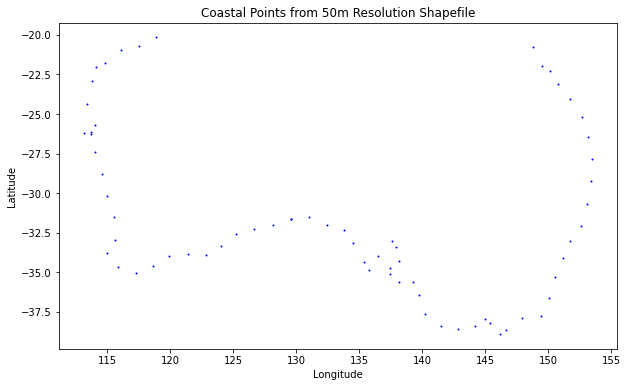

In [30]:
# Load the 50m resolution coastline data
coastline = gpd.read_file(shapefile_path)

# Verify that the data is loaded correctly
if coastline.empty:
    raise FileNotFoundError("The shapefile path is incorrect or the file is empty. Please check the path and try again.")

# Set the CRS of the coastline data (assuming it's EPSG:4326)
if coastline.crs is None:
    coastline.set_crs("EPSG:4326", inplace=True)

# Ensure the coastline is in the geographic coordinate system (e.g., WGS84)
if coastline.crs != "EPSG:4326":
    coastline = coastline.to_crs("EPSG:4326")

# Function to resample a LineString to ensure uniform spacing of points
def resample_linestring(line, sampling_distance):
    num_points = int(line.length / sampling_distance)
    return [line.interpolate(float(i) / num_points, normalized=True) for i in range(num_points + 1)]

# Function to extract coordinates from geometries
def extract_coordinates(geometry, min_lon, max_lon, min_lat, max_lat, sampling_distance=1.5, min_length=10.0, min_area=1.0):
    coords = []
    if geometry.is_empty:
        return coords
    if isinstance(geometry, LineString):
        if geometry.length >= min_length:
            line = geometry
            if min_lon <= line.bounds[2] and max_lon >= line.bounds[0] and min_lat <= line.bounds[3] and max_lat >= line.bounds[1]:
                resampled_coords = resample_linestring(line, sampling_distance)
                for point in resampled_coords:
                    lon, lat = point.x, point.y
                    if min_lon <= lon <= max_lon and min_lat <= lat <= max_lat:
                        coords.append((lon, lat))
    elif isinstance(geometry, MultiLineString):
        for line in geometry:
            coords.extend(extract_coordinates(line, min_lon, max_lon, min_lat, max_lat, sampling_distance, min_length, min_area))
    elif isinstance(geometry, Polygon):
        if geometry.area >= min_area:
            exterior = geometry.exterior
            if min_lon <= exterior.bounds[2] and max_lon >= exterior.bounds[0] and min_lat <= exterior.bounds[3] and max_lat >= exterior.bounds[1]:
                resampled_coords = resample_linestring(exterior, sampling_distance)
                for point in resampled_coords:
                    lon, lat = point.x, point.y
                    if min_lon <= lon <= max_lon and min_lat <= lat <= max_lat:
                        coords.append((lon, lat))
    elif isinstance(geometry, MultiPolygon):
        for poly in geometry:
            coords.extend(extract_coordinates(poly, min_lon, max_lon, min_lat, max_lat, sampling_distance, min_length, min_area))
    return coords

# Define the bounding box (example values, adjust as needed)
# min_lon, max_lon = 3, 9
# min_lat, max_lat = 51, 56

# Extract coordinates within the bounding box
north_sea_coords = []
for geom in coastline.geometry:
    north_sea_coords.extend(extract_coordinates(geom, min_lon, max_lon, min_lat, max_lat))

# Unzip the coordinates into separate lists of longitudes and latitudes
if north_sea_coords:  # Ensure there are coordinates before unpacking
    lons, lats = zip(*north_sea_coords)
else:
    lons, lats = [], []

# Convert the lists to numpy arrays
longitude = np.array(lons)
latitude = np.array(lats)

# Create numeric names for the locations (1, 2, 3, ...)
selected_locations = [str(i + 1) for i in range(len(latitude))]

# Create the locations dictionary
locations = {
    selected_locations[i]: {'latitude': latitude[i], 'longitude': longitude[i]}
    for i in range(len(latitude))
}

# Plot the results to verify
plt.figure(figsize=(10, 6))
plt.scatter(longitude, latitude, s=1, color='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coastal Points from 50m Resolution Shapefile')
plt.show()

In [31]:
import os
import numpy as np
from scipy.signal import butter, filtfilt
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Define Butterworth bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

def interpolate_nan(data):
    """Interpolate NaNs in the data."""
    nans, x = np.isnan(data), lambda z: z.nonzero()[0]
    data[nans] = np.interp(x(nans), x(~nans), data[~nans])
    return data

def find_nearest_non_nan(dataset, lat_idx, lon_idx):
    """Find the nearest non-NaN value in the dataset around the given indices."""
    max_radius = 5  # Define the maximum search radius
    for radius in range(1, max_radius + 1):
        for dlat in range(-radius, radius + 1):
            for dlon in range(-radius, radius + 1):
                if abs(dlat) == radius or abs(dlon) == radius:
                    new_lat_idx = lat_idx + dlat
                    new_lon_idx = lon_idx + dlon
                    if (0 <= new_lat_idx < dataset.dims['latitude']) and (0 <= new_lon_idx < dataset.dims['longitude']):
                        sla_data_point = dataset['sla'].isel(latitude=new_lat_idx, longitude=new_lon_idx).values.item()
                        if not np.isnan(sla_data_point):
                            return sla_data_point
    return np.nan


# Initialize dictionaries to store unfiltered and filtered time series
unfiltered_sla_time_series = {}
filtered_sla_time_series = {}

# Frequency cutoffs in cycles per day
lowcut = 0.035
highcut = 0.15
fs = 1.0  # Sampling frequency in cycles per day

# Iterate through each location
for location, coords in locations.items():
    latitude = coords['latitude']
    longitude = coords['longitude']
    
    # Initialize an empty list to store sla data for the location
    sla_data = []
    
    if mission in {'cmems'} :
        # Convert the date strings to integers in the format YYYYMMDD
        start_date_int = int(datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d'))
        end_date_int = int(datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d'))        
        
        # Iterate through each month directory in the base directory
        for month in range(1, 13):
            month_str = f"{month:02d}"  # Format month as two digits
            month_dir = os.path.join(base_dir, month_str)

            # Check if the month directory exists
            if os.path.isdir(month_dir):
                # Iterate through each file in the month directory
                for file_name in os.listdir(month_dir):
                    if file_name.endswith('.nc'):
                        # Extract the date from the file name
                        file_date_str = file_name.split('_')[5]
                        file_date = int(file_date_str)

                        # Check if the file date is within the specified date range
                        if start_date_int <= file_date <= end_date_int:
                            file_path = os.path.join(month_dir, file_name)

                            # Open the dataset for the current file
                            dataset = xr.open_dataset(file_path)

                            # Find nearest indices to the specified latitude and longitude
                            lat_idx = abs(dataset.latitude - latitude).argmin()
                            lon_idx = abs(dataset.longitude - longitude).argmin()

                            # Extract sla at the specified point for the current file
                            sla_data_point = dataset['sla'].isel(latitude=lat_idx, longitude=lon_idx).values.item()

                            # Check if sla_data_point is NaN and find the nearest non-NaN value if necessary
                            if np.isnan(sla_data_point):
                                sla_data_point = find_nearest_non_nan(dataset, lat_idx, lon_idx)

                            # Append sla data point to the list
                            sla_data.append(sla_data_point)

                            # Close the dataset
                            dataset.close()
                    
    elif mission in {'swot_science'} :
            # Iterate through each file in the base directory
            for file_name in os.listdir(base_dir):
                if file_name.endswith('.nc'):
                    # Extract the date from the file name
                    file_date_str = file_name.split('_')[5]
                    file_date = int(file_date_str)

                    # Check if the file date is after the cutoff date
                    if file_date >= cutoff_date:
                        file_path = os.path.join(base_dir, file_name)

                        # Open the dataset for the current file
                        dataset = xr.open_dataset(file_path)

                        # Find nearest indices to the specified latitude and longitude
                        lat_idx = abs(dataset.latitude - latitude).argmin()
                        lon_idx = abs(dataset.longitude - longitude).argmin()

                        # Extract sla at the specified point for the current file
                        sla_data_point = dataset['sla'].isel(latitude=lat_idx, longitude=lon_idx).values.item()

                        # Check if sla_data_point is NaN and find the nearest non-NaN value if necessary
                        if np.isnan(sla_data_point):
                            sla_data_point = find_nearest_non_nan(dataset, lat_idx, lon_idx)

                        # Append sla data point to the list
                        sla_data.append(sla_data_point)

                        # Close the dataset
                        dataset.close()                    
    
    # Convert the list to xarray DataArray with time dimension
    time_index = pd.date_range(start=start_date, end=end_date, freq='D')
    sla_time_series_da = xr.DataArray(sla_data, dims=['time'], coords={'time': time_index})
    
    # Store unfiltered series in dictionary
    unfiltered_sla_time_series[location] = sla_time_series_da.values
    
    # Apply the Butterworth bandpass filter to the time series
    series = sla_time_series_da.values
    nan_count = np.isnan(series).sum()  # Count NaNs
    
    # Apply filtering only if less than or equal to 90% NaNs
    if nan_count <= 0.9 * len(sla_time_series_da.time):
        if nan_count > 0:
            series = interpolate_nan(series)  # Interpolate NaNs
        filtered_series = butter_bandpass_filter(series, lowcut, highcut, fs, order=5)  # Apply filter
    else:
        print(f"Skipping location '{location}' due to excessive NaNs.")
        filtered_series = np.full_like(series, np.nan)  # Create NaN-filled array
    
    # Store filtered series in dictionary
    filtered_sla_time_series[location] = filtered_series
    

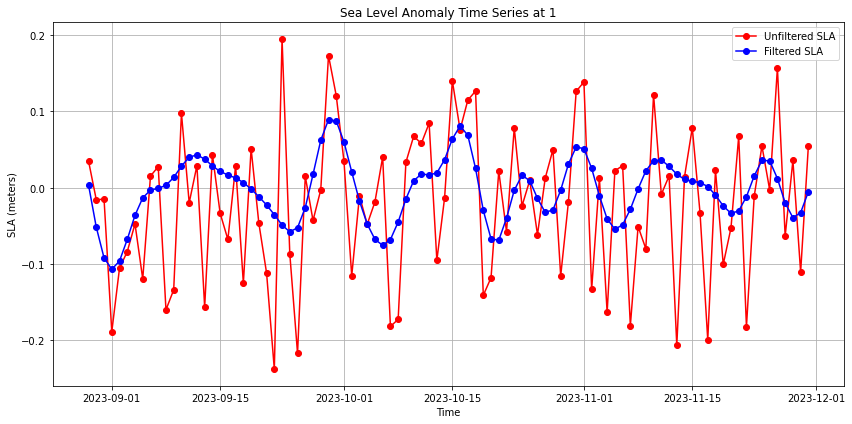

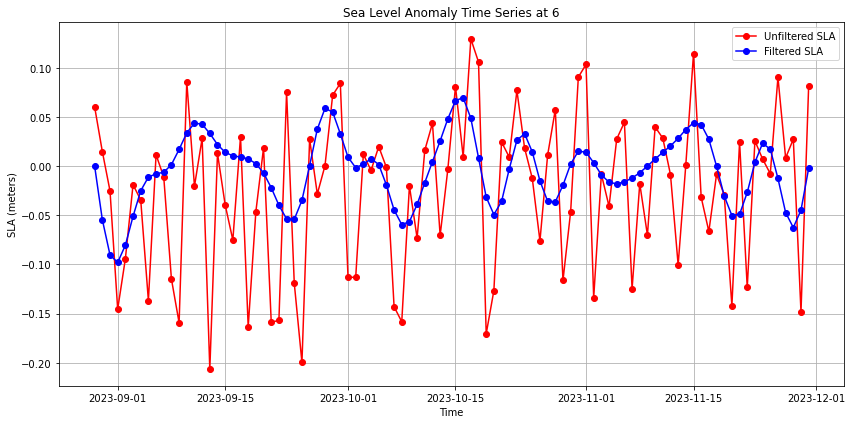

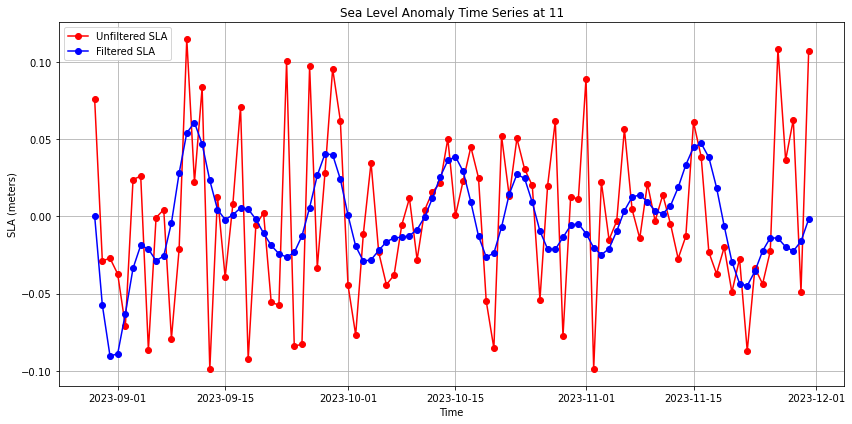

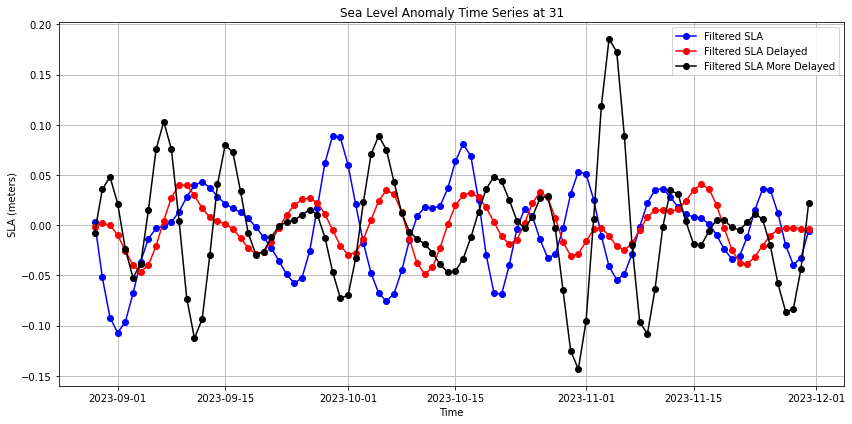

In [32]:
# Example plot of one location's unfiltered and filtered time series (e.g., 'Eden')
location = selected_locations[0]
plt.figure(figsize=(12, 6))
plt.plot(time_index, unfiltered_sla_time_series[location], marker='o', linestyle='-', color='r', label='Unfiltered SLA')
plt.plot(time_index, filtered_sla_time_series[location], marker='o', linestyle='-', color='b', label='Filtered SLA')
plt.title(f'Sea Level Anomaly Time Series at {location}')
plt.xlabel('Time')
plt.ylabel('SLA (meters)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Example plot of one location's unfiltered and filtered time series (e.g., 'Eden')
location = selected_locations[5]
plt.figure(figsize=(12, 6))
plt.plot(time_index, unfiltered_sla_time_series[location], marker='o', linestyle='-', color='r', label='Unfiltered SLA')
plt.plot(time_index, filtered_sla_time_series[location], marker='o', linestyle='-', color='b', label='Filtered SLA')
plt.title(f'Sea Level Anomaly Time Series at {location}')
plt.xlabel('Time')
plt.ylabel('SLA (meters)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# Example plot of one location's unfiltered and filtered time series (e.g., 'Eden')
location = selected_locations[10]
plt.figure(figsize=(12, 6))
plt.plot(time_index, unfiltered_sla_time_series[location], marker='o', linestyle='-', color='r', label='Unfiltered SLA')
plt.plot(time_index, filtered_sla_time_series[location], marker='o', linestyle='-', color='b', label='Filtered SLA')
plt.title(f'Sea Level Anomaly Time Series at {location}')
plt.xlabel('Time')
plt.ylabel('SLA (meters)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Example plot of one location's unfiltered and filtered time series (e.g., 'Eden')
location = selected_locations[0]
plt.figure(figsize=(12, 6))
plt.plot(time_index, filtered_sla_time_series[location], marker='o', linestyle='-', color='b', label='Filtered SLA')

location = selected_locations[15]
plt.plot(time_index, filtered_sla_time_series[location], marker='o', linestyle='-', color='r', label='Filtered SLA Delayed')

location = selected_locations[30]
plt.plot(time_index, filtered_sla_time_series[location], marker='o', linestyle='-', color='k', label='Filtered SLA More Delayed')


plt.title(f'Sea Level Anomaly Time Series at {location}')
plt.xlabel('Time')
plt.ylabel('SLA (meters)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
file_name

'dt_global_allsat_phy_l4_20230914_20240501.nc'

In [34]:
np.shape(sla_data)

(94,)

Shape of filtered_sla_array_cmems: (94, 69)
Shape of unfiltered_sla_array_cmems: (94, 69)


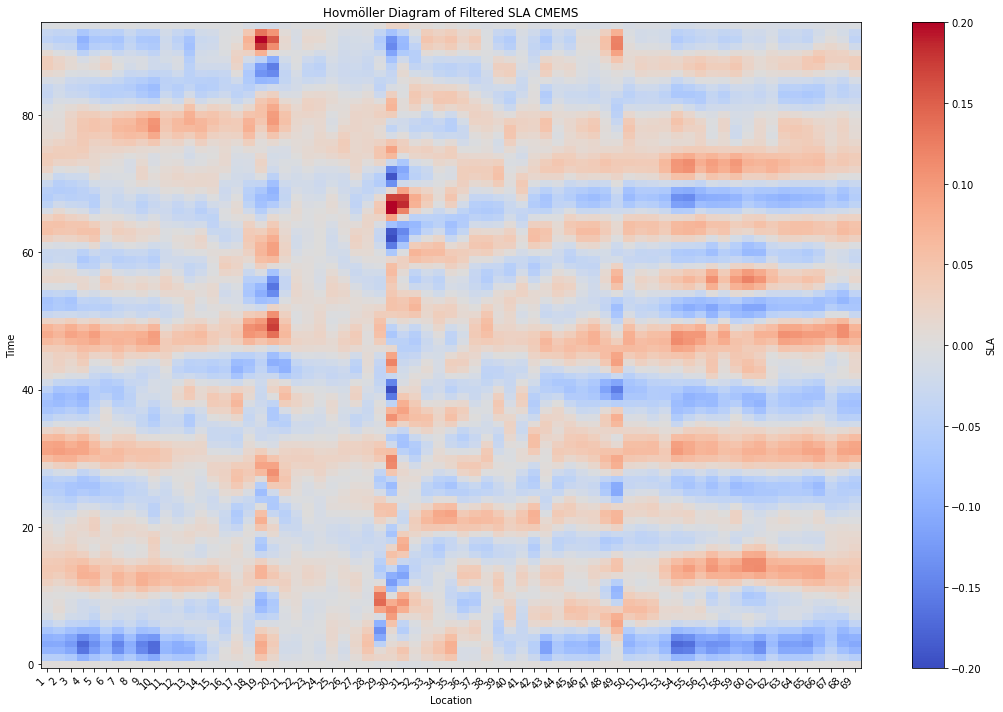

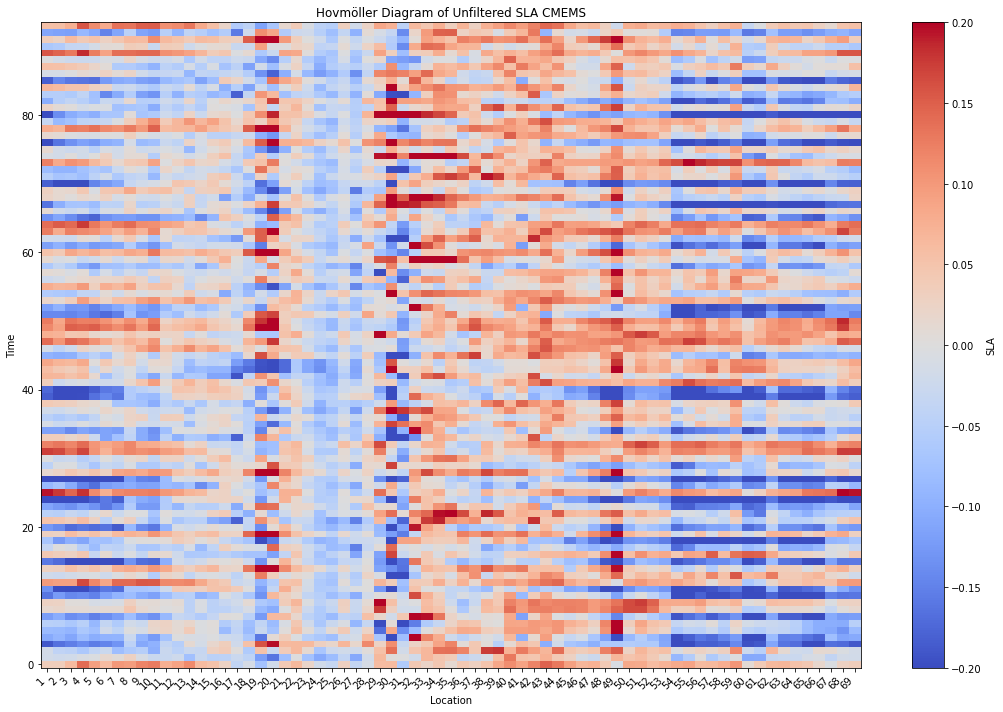

Latitude and Longitude for Selected Locations:
1: Latitude -31.627246093750003, Longitude 129.56884765625
2: Latitude -32.038751881983146, Longitude 128.14192873967897
3: Latitude -32.302265459698155, Longitude 126.6762655225329
4: Latitude -32.61781520150915, Longitude 125.2602372385657
5: Latitude -33.338597949581676, Longitude 124.02118239698558
6: Latitude -33.888245260495395, Longitude 122.84277371328356
7: Latitude -33.827535450595484, Longitude 121.41214060868678
8: Latitude -33.96637801978695, Longitude 119.92947704434731
9: Latitude -34.63358538364418, Longitude 118.67111915211242
10: Latitude -35.055421128369055, Longitude 117.2925090376585
11: Latitude -34.6829701360312, Longitude 115.87820904155828
12: Latitude -33.786256593957965, Longitude 114.97681183182011
13: Latitude -32.93889336527562, Longitude 115.66101944020622
14: Latitude -31.519077147508522, Longitude 115.589292284773
15: Latitude -30.162575524439003, Longitude 114.98661091668446
16: Latitude -28.77541460831947

In [35]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Assuming filtered_sla_time_series and unfiltered_sla_time_series are already defined as dictionaries
# Assuming filtered_sla_ml_time_series and unfiltered_sla_ml_time_series are already defined as dictionaries

# Extract time series and convert to numpy arrays for filtered CMEMS data
filtered_time_series_arrays_cmems = [filtered_sla_time_series[location] for location in filtered_sla_time_series]
filtered_sla_array_cmems = np.stack(filtered_time_series_arrays_cmems, axis=1)

# Extract time series and convert to numpy arrays for unfiltered CMEMS data
unfiltered_time_series_arrays_cmems = [unfiltered_sla_time_series[location] for location in unfiltered_sla_time_series]
unfiltered_sla_array_cmems = np.stack(unfiltered_time_series_arrays_cmems, axis=1)



# Verify the shape of the resulting arrays
print("Shape of filtered_sla_array_cmems:", filtered_sla_array_cmems.shape)
print("Shape of unfiltered_sla_array_cmems:", unfiltered_sla_array_cmems.shape)
# Expected output: (366, 14) if leap year, otherwise (365, 14)

# Define valid site names and coordinates for the x-axis labels
valid_site_names = list(filtered_sla_time_series.keys())
valid_latitudes = [locations[location]['latitude'] for location in valid_site_names]
valid_longitudes = [locations[location]['longitude'] for location in valid_site_names]

# Function to create Hovmöller diagram
def plot_hovmoller(data_array, title):
    fig, ax = plt.subplots(figsize=(15, 10))
    norm = Normalize(vmin=-0.2, vmax=0.2)
    im = ax.imshow(data_array, aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
    ax.set_xlabel('Location')
    ax.set_ylabel('Time')
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('SLA')
    ax.set_xticks(np.arange(len(valid_site_names)))
    ax.set_xticklabels(valid_site_names, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot Hovmöller diagrams for filtered CMEMS 
plot_hovmoller(filtered_sla_array_cmems, 'Hovmöller Diagram of Filtered SLA CMEMS')


# Plot Hovmöller diagrams for unfiltered CMEMS 
plot_hovmoller(unfiltered_sla_array_cmems, 'Hovmöller Diagram of Unfiltered SLA CMEMS')


# Print latitude and longitude for each selected location
print("Latitude and Longitude for Selected Locations:")
for name, lat, lon in zip(valid_site_names, valid_latitudes, valid_longitudes):
    print(f"{name}: Latitude {lat}, Longitude {lon}")

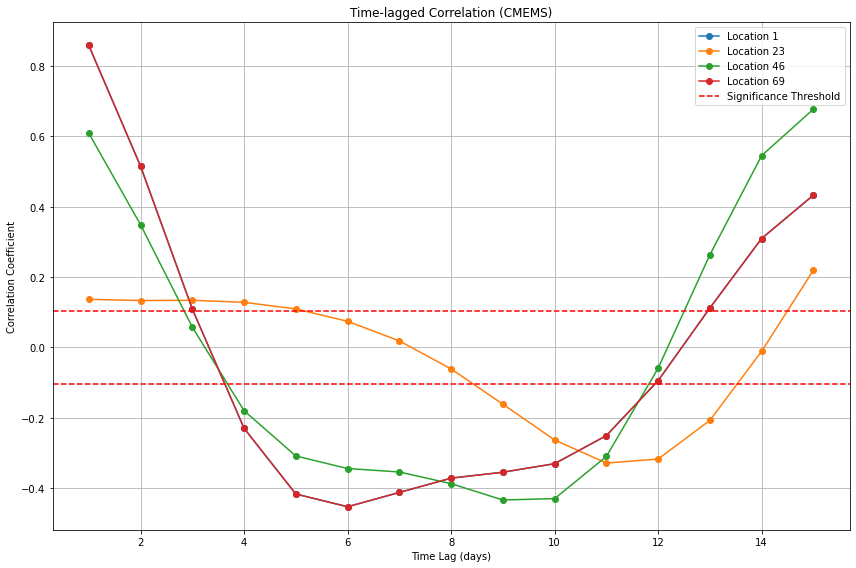

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t


# Function to compute time-lagged correlation
def time_lagged_correlation(data, max_lag=15):
    num_locations = data.shape[1]
    correlations = np.zeros((num_locations, max_lag))
    for loc in range(num_locations):
        for lag in range(1, max_lag + 1):
            correlation = np.corrcoef(data[:-lag, 0], data[lag:, loc])[0, 1]
            correlations[loc, lag-1] = correlation
    return correlations

# Function to select up to 4 equally spaced locations
def select_locations(num_locations):
    indices = np.linspace(0, num_locations - 1, min(4, num_locations), dtype=int)
    return indices

# Function to compute the significance threshold for correlation coefficients
def compute_significance_threshold(n, alpha=0.05):
    df = n - 2  # degrees of freedom
    t_critical = t.ppf(1 - alpha/2, df)
    r_threshold = np.sqrt(t_critical**2 / (t_critical**2 + df))
    return r_threshold

# Plotting function for each dataset
def plot_time_lagged_correlations(correlations, title, n, alpha=0.05):
    lags = np.arange(1, correlations.shape[1] + 1)
    selected_indices = select_locations(correlations.shape[0])
    r_threshold = compute_significance_threshold(n, alpha)

    plt.figure(figsize=(12, 8))
    for loc in selected_indices:
        plt.plot(lags, correlations[loc], marker='o', label=f'Location {loc+1}')
    
    plt.axhline(y=r_threshold, color='r', linestyle='--', label='Significance Threshold')
    plt.axhline(y=-r_threshold, color='r', linestyle='--')
    plt.xlabel('Time Lag (days)')
    plt.ylabel('Correlation Coefficient')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Compute time-lagged correlations for each dataset
max_lag = 15
n = 366  # number of samples
corr_cmems = time_lagged_correlation(filtered_sla_array_cmems, max_lag)


# Plot the time-lagged correlations for each dataset
plot_time_lagged_correlations(corr_cmems, 'Time-lagged Correlation (CMEMS)', n)



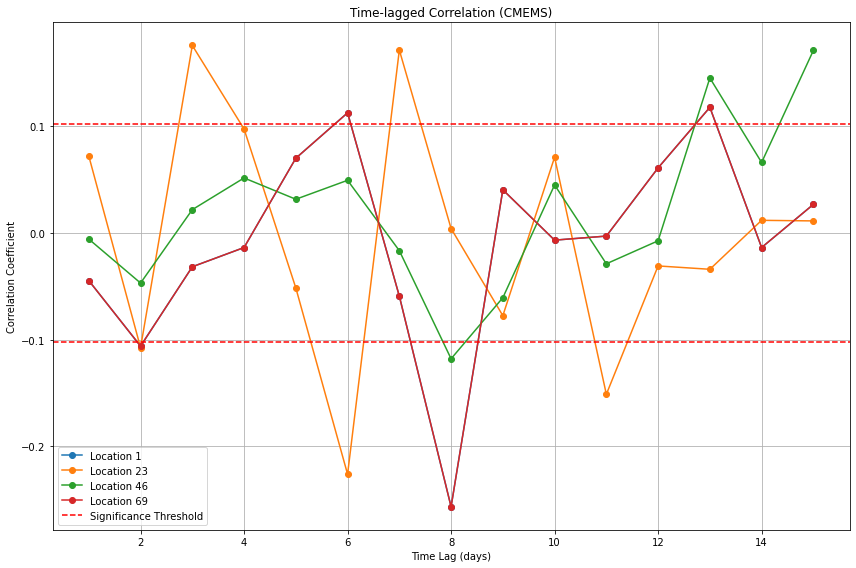

In [37]:
# Compute time-lagged correlations for each dataset
max_lag = 15
n = 366  # number of samples
corr_cmems_unfiltered = time_lagged_correlation(unfiltered_sla_array_cmems, max_lag)


# Plot the time-lagged correlations for each dataset
plot_time_lagged_correlations(corr_cmems_unfiltered, 'Time-lagged Correlation (CMEMS)', n)

Reference Location: 7


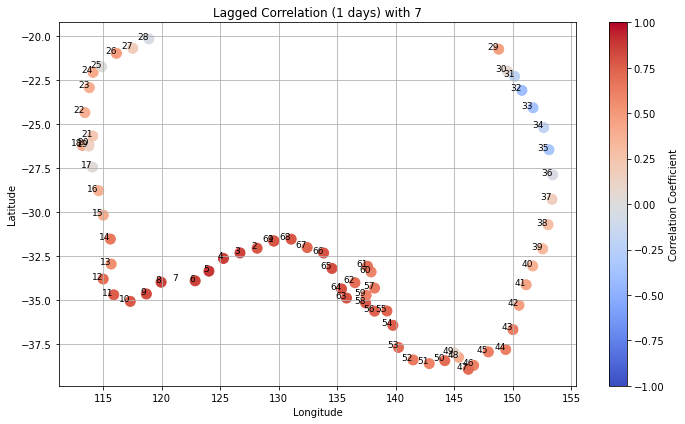

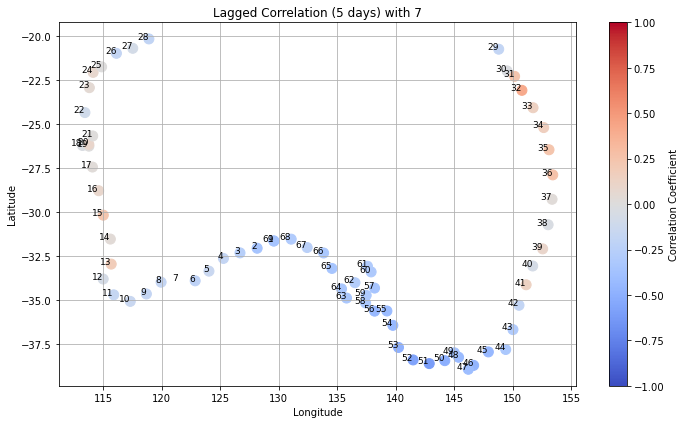

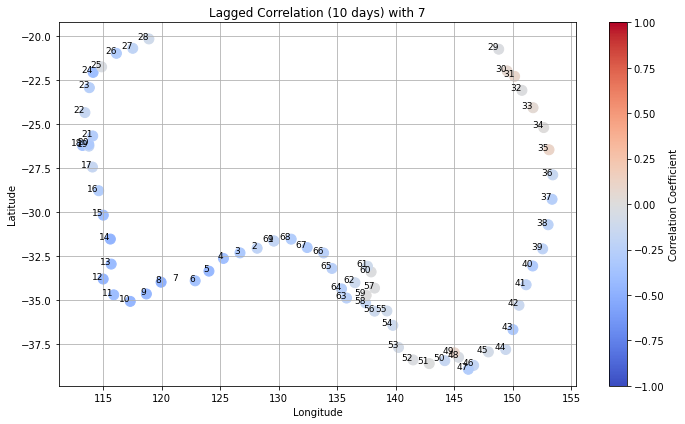

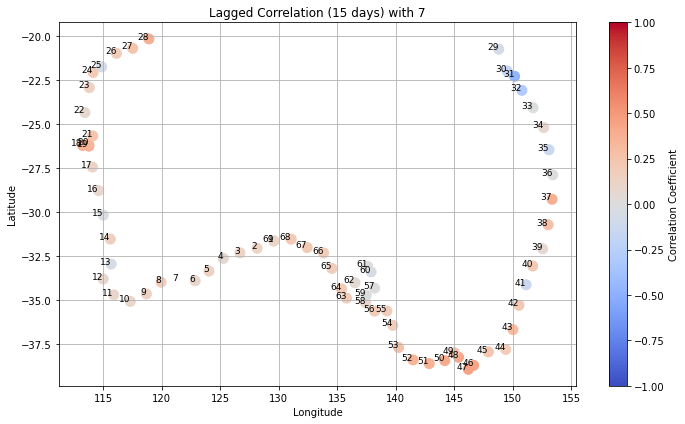

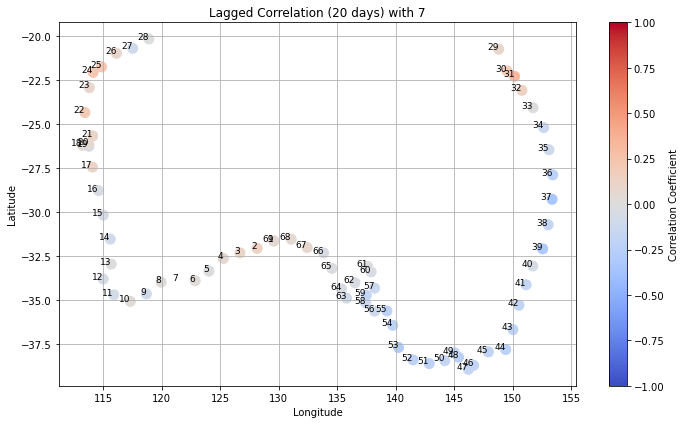

In [44]:
# Select the first location as the reference
reference_index = 6
reference_location = valid_site_names[reference_index]

# Print the reference location
print(f"Reference Location: {reference_location}")

# Compute the correlation of all other locations with the reference location
reference_series = filtered_sla_array_cmems[:, reference_index]

def compute_lagged_correlation(data, reference_series, lag):
    num_locations = data.shape[1]
    correlations = np.zeros(num_locations)
    for loc in range(num_locations):
        if loc == reference_index:
            correlations[loc] = np.nan  # Skip self-correlation
        else:
            correlations[loc] = np.corrcoef(reference_series[:-lag], data[lag:, loc])[0, 1]
    return correlations

# Compute the correlations and lagged correlations
correlation_1 = compute_lagged_correlation(filtered_sla_array_cmems, reference_series, 1)
correlation_5 = compute_lagged_correlation(filtered_sla_array_cmems, reference_series, 5)
correlation_10 = compute_lagged_correlation(filtered_sla_array_cmems, reference_series, 10)
correlation_15 = compute_lagged_correlation(filtered_sla_array_cmems, reference_series, 15)
correlation_20 = compute_lagged_correlation(filtered_sla_array_cmems, reference_series, 20)

# Function to plot the correlation maps
def plot_correlation_map(correlations, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    sc = ax.scatter(valid_longitudes, valid_latitudes, c=correlations, cmap='coolwarm', norm=Normalize(vmin=-1, vmax=1), s=100)
    plt.colorbar(sc, ax=ax, label='Correlation Coefficient')
    for i, txt in enumerate(valid_site_names):
        ax.annotate(txt, (valid_longitudes[i], valid_latitudes[i]), fontsize=9, ha='right')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the correlation maps
plot_correlation_map(correlation_1, f'Lagged Correlation (1 days) with {reference_location}')
plot_correlation_map(correlation_5, f'Lagged Correlation (5 days) with {reference_location}')
plot_correlation_map(correlation_10, f'Lagged Correlation (10 days) with {reference_location}')
plot_correlation_map(correlation_15, f'Lagged Correlation (15 days) with {reference_location}')
plot_correlation_map(correlation_20, f'Lagged Correlation (20 days) with {reference_location}')